In [1]:
from matplotlib import pyplot as plt
import numpy as np

[ 000000.00 ]   0: 01-07 15:17  Hmf             INFO     Logger initialized at level: 20
[ 000000.00 ]   0: 01-07 15:17  Hmf             INFO     MPI_COMM_WORLD | size = 1 -- Nbkit COMM | size = 1
[ 000000.05 ]   0: 01-07 15:17  CatalogSource   INFO     Extra arguments to FileType: () {'dataset': 'FOFGroups'}
[ 000000.65 ]   0: 01-07 15:17  CatalogSource   INFO     Extra arguments to FileType: () {'dataset': 'FOFGroups'}
[ 000000.69 ]   0: 01-07 15:17  CatalogSource   INFO     Extra arguments to FileType: () {'dataset': 'FOFGroups'}
[ 000000.97 ]   0: 01-07 15:17  CatalogSource   INFO     Extra arguments to FileType: () {'dataset': 'FOFGroups'}
[ 000001.59 ]   0: 01-07 15:17  CatalogSource   INFO     Extra arguments to FileType: () {'dataset': 'FOFGroups'}
[ 000001.64 ]   0: 01-07 15:17  CatalogSource   INFO     Extra arguments to FileType: () {'dataset': 'FOFGroups'}
[ 000002.00 ]   0: 01-07 15:17  CatalogSource   INFO     Extra arguments to FileType: () {'dataset': 'FOFGroups'}
[ 000

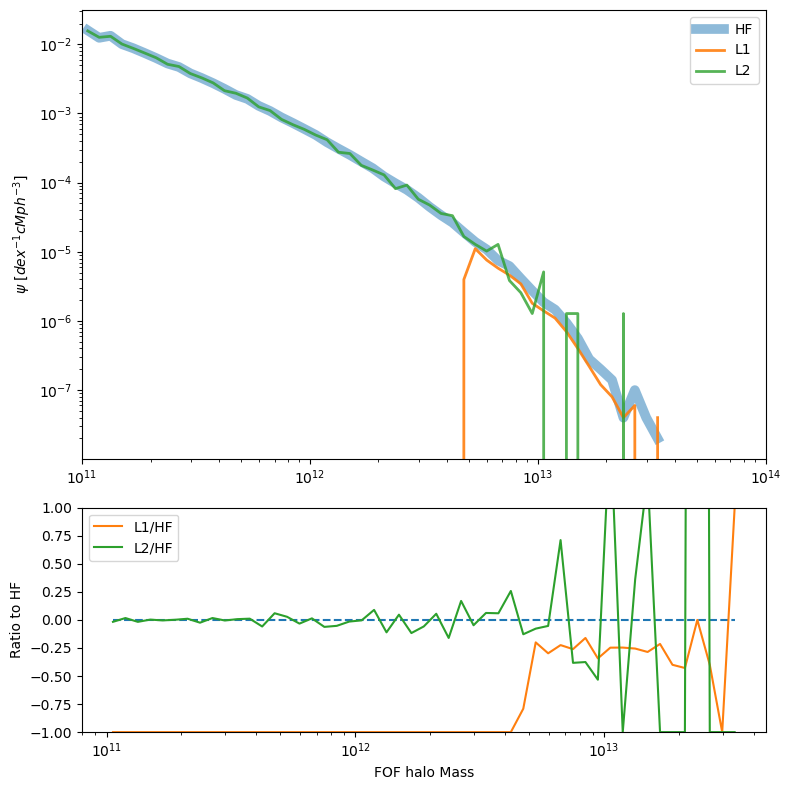

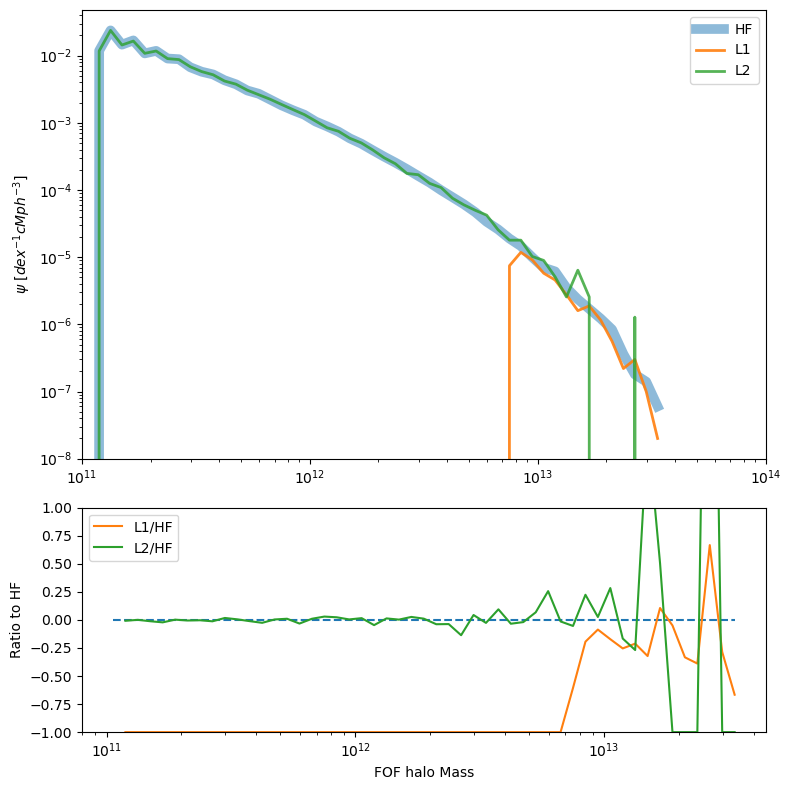

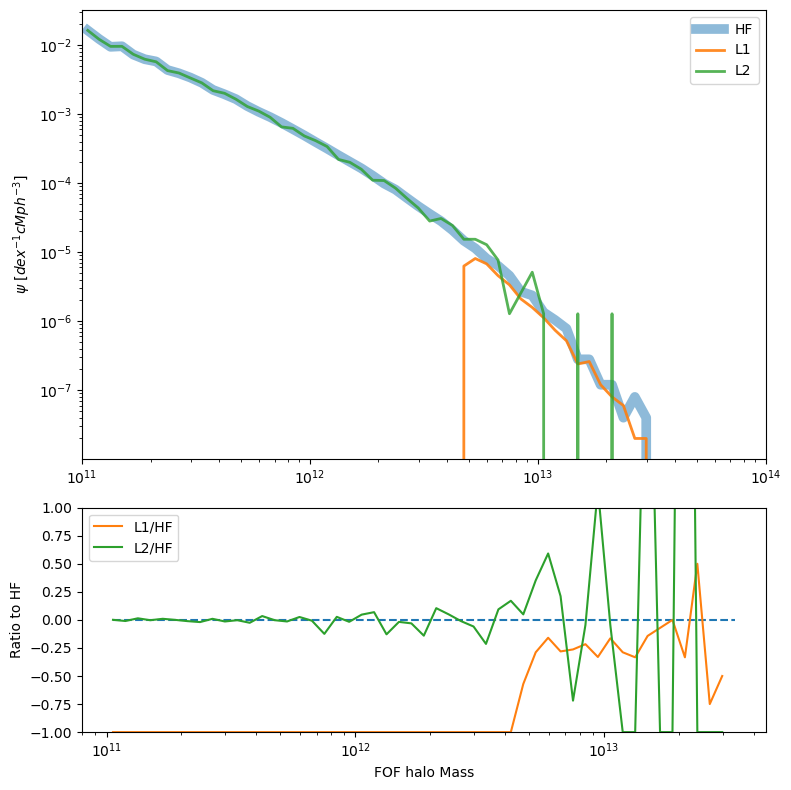

In [5]:
from gal_goku import hmf

hmf = hmf.Hmf()
nums = ['0024', '0026', '0072']
bins = np.arange(11, 13.55, 0.05)
for n in nums:
    pig_dirs = [f'/scratch/06536/qezlou/Goku/FOF/HF/compressed_10p_Box1000_Part3000_{n}/output/PIG_003/',
                f'/scratch/06536/qezlou/Goku/FOF/L1/cosmo_10p_Box1000_Part750_{n}/output/PIG_003/',
                f'/scratch/06536/qezlou/Goku/FOF/L2/cosmo_10p_Box250_Part750_{n}/output/PIG_003/']
    vol = {'HF':1000**3, 'L1':1000**3, 'L2':250**3}
    
    labels = ['HF', 'L1', 'L2']
    lws = [7, 2, 2]
    alphas = [0.5, 0.9, 0.8]
    fig, ax = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [2, 1]})
    psi = {}
    psi_mbins = {}
    for i in range(3):
        psi[labels[i]] = hmf.get_fof_hmf(pig_dirs[i], bins=bins, vol=vol[labels[i]])
        psi_mbins[labels[i]] = 0.5*(10**bins[1:]+10**bins[:-1])
        ax[0].plot(psi_mbins[labels[i]], psi[labels[i]], label=labels[i], lw=lws[i], alpha=alphas[i])
        
    ax[1].plot(psi_mbins['HF'], np.zeros_like(psi_mbins['HF']), ls='dashed')
    ax[1].plot(psi_mbins['L1'], psi['L1']/psi['HF'] -1, label='L1/HF')
    ax[1].plot(psi_mbins['L2'], psi['L2']/psi['HF'] -1, label='L2/HF')
    ax[1].set_ylim((-1,1))
    for i in range(2):
        ax[i].set_xscale('log')
        ax[i].legend()
    ax[0].set_yscale('log')
    ax[1].set_xlabel('FOF halo Mass')
    ax[0].set_ylabel(r'$\psi \ [dex^{-1} cMph^{-3}]$')
    ax[0].set_xlim(1e11, 1e14)
    ax[0].set_xlim(1e11, 1e14)
    ax[1].set_ylabel('Ratio to HF')
    fig.tight_layout()




In [10]:
psi['L2'].compute()

array([0.])

In [3]:
from gal_goku import plot

save_dir = '/scratch/06536/qezlou/Goku/processed_data/HMF/'
plt_hmf = plot.PlotHMF()

plt_hmf.sim_hmf(save_dir=save_dir)

ModuleNotFoundError: No module named 'gpflow'

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from gal_goku import hmf

base_dir= '/scratch/06536/qezlou/Goku/FOF/L2/'
save_file = '/scratch/06536/qezlou/Goku/processed_data/HMF/L2_hmfs.hdf5'
hmf = hmf.Hmf()

bins = np.arange(11, 13.55, 0.05)
pigs = hmf.get_all_fof_hmfs(base_dir=base_dir, bins=bins, save_file=save_file)

[ 000000.00 ]   0: 01-07 15:56  Hmf             INFO     Logger initialized at level: 20
[ 000000.00 ]   0: 01-07 15:56  Hmf             INFO     MPI_COMM_WORLD | size = 1 -- Nbkit COMM | size = 1
[ 000000.26 ]   0: 01-07 15:56  Hmf             INFO     base_dir = /scratch/06536/qezlou/Goku/FOF/L2/ | number of sims = 565, z = 2.5
[ 000002.32 ]   0: 01-07 15:56  CatalogSource   INFO     Extra arguments to FileType: () {'dataset': 'FOFGroups'}
[ 000002.45 ]   0: 01-07 15:56  CatalogSource   INFO     Extra arguments to FileType: () {'dataset': 'FOFGroups'}
[ 000002.60 ]   0: 01-07 15:56  CatalogSource   INFO     Extra arguments to FileType: () {'dataset': 'FOFGroups'}
[ 000002.74 ]   0: 01-07 15:56  CatalogSource   INFO     Extra arguments to FileType: () {'dataset': 'FOFGroups'}
[ 000002.89 ]   0: 01-07 15:56  CatalogSource   INFO     Extra arguments to FileType: () {'dataset': 'FOFGroups'}
[ 000003.00 ]   0: 01-07 15:56  CatalogSource   INFO     Extra arguments to FileType: () {'dataset